<a href="https://colab.research.google.com/github/dpanagop/data_analytics_examples/blob/master/Movies_Neo4j.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install graph libraries

In [ ]:
%%capture
!pip install neo4j-driver
!pip install graphdatascience

Load libraries

In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience

Connect to Neo4j database and test

In [ ]:
# Neo4j Connection details
DB_ULR = 'bolt://xxxx:7687'
DB_USER = 'neo4j'
DB_PASS = 'xxxx'
gds = GraphDataScience(DB_ULR, auth=(DB_USER, DB_PASS))
gds.version()

'2.3.0'

In [ ]:
nodes = gds.run_cypher('''
    MATCH (n)
    RETURN COUNT(n)
''') 
nodes.head()

,COUNT(n)
0,9923


## Load MovieLens data.
Here we use data from [GroupLens.org](https://grouplens.org/datasets/movielens/). Espesially, the "[1M Dataset](https://files.grouplens.org/datasets/movielens/ml-1m.zip)". The zip file is decompressed and the contens are placed in the same folder as the notebook (or in case of colab are uploaded to colab).   

For better results it is suggested that a bigger dataset is used.

In [ ]:
movies = pd.read_csv('movies.dat',sep='::',encoding = "ISO-8859-1",names=['MovieID','Title','Genres'])
ratings = pd.read_csv('ratings.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','MovieID','Rating','Timestamp'])
users = pd.read_csv('users.dat',sep='::',encoding = "ISO-8859-1",names=['UserID','Gender','Age','Occupation','Zip_code'])

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [ ]:
display(movies.head())
display(users.head())
display(ratings.head())

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


,UserID,Gender,Age,Occupation,Zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## Insert data to graph DB

In [ ]:
# Create user nodes
gds.run_cypher('create constraint if not exists for (n:User) require (n.id) is node key')
create_customer_res = gds.run_cypher('''
    unwind $data as row
    merge (n:User{id: row.UserID})
    set n.Gender = row.Gender
    set n.Age =  row.Age 
    return count(*) as custmers_created
''', params = {'data': users.to_dict('records')})
create_customer_res.head()

,custmers_created
0,6040


In [ ]:
# Create movies nodes
gds.run_cypher('create constraint if not exists for (n:Movie) require (n.id) is node key')
create_customer_res = gds.run_cypher('''
    unwind $data as row
    merge (n:Movie{id: row.MovieID})
    set n.Title = row.Title
    set n.Genres =  row.Genres 
    return count(*) as movies_created
''', params = {'data': movies.to_dict('records')})
create_customer_res.head()

,movies_created
0,3883


Ratings data frame is quite large dataframe, hence we split it in chunks and then upload one chunk at a time.

In [ ]:
# Create rated relationship
i=1
for chunk in np.array_split(ratings,200):
  if i%10 == 0:
    print(i)
  create_rated = gds.run_cypher('''
    unwind $data as row
    match (u:User{id: row.UserID}), (m:Movie{id: row.MovieID})
    merge (u)-[r:RATED]->(m)
    set r.Rating = row.Rating
    return count(*) as create_rated
    ''', params = {'data': chunk.to_dict('records')})
  i = i+1
create_rated.head()

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


,create_rated
0,5001


* To get schema use
```
  CALL apoc.meta.schema()
```
* To visualize schem use
```
  CALL db.schema.visualization()
```
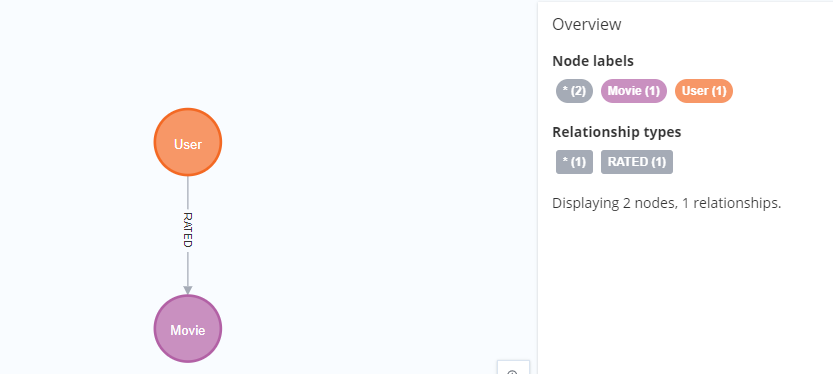


## Recommendations

### Recomendation of similar movie
A simple way to find similar movies for a specific movie is to count how many paths of the form  
$(movie_1)-[]\rightarrow(user)-[]\rightarrow(movie_2)$  
there are,   
where $movie_1$ is the movie we want to find similar movies for.  
We order $movie_2$ based on the number of paths that connect the two movies. The idea is that similar movies would recieve excellent rating by the same user.


In [ ]:
# Check similar movies
similar_movies = gds.run_cypher('''
    MATCH(m1:Movie)-[r1]-(u:User)-[r2]-(m2:Movie)
    WHERE m1.Title CONTAINS 'Toy Story (1995)'
      AND m2.Title<>'Toy Story (1995)'
      AND r1.Rating=5 AND r2.Rating=5
    RETURN m2.Title,m2.Genres,count(DISTINCT(u)) as common_users
    ORDER BY common_users DESC
''')
similar_movies.head()

,m2.Title,m2.Genres,common_users
0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,401
1,Toy Story 2 (1999),Animation|Children's|Comedy,385
2,Raiders of the Lost Ark (1981),Action|Adventure,373
3,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,346
4,"Shawshank Redemption, The (1994)",Drama,327


And a parametric query

In [ ]:
# Check similar movies
similar_movies = gds.run_cypher('''
    MATCH(m1:Movie)-[r1]-(u:User)-[r2]-(m2:Movie)
    WHERE m1.Title CONTAINS $title
        AND m2.Title<>$title
        AND r1.Rating=5 AND r2.Rating=5
    RETURN m2.Title,m2.Genres,count(DISTINCT(u)) as common_users
    ORDER BY common_users DESC
''',params = {'title':'Matrix, The (1999)'})
similar_movies.head()

,m2.Title,m2.Genres,common_users
0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,799
1,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,686
2,Raiders of the Lost Ark (1981),Action|Adventure,613
3,American Beauty (1999),Comedy|Drama,590
4,"Sixth Sense, The (1999)",Thriller,557


In [ ]:
similar_movies.head(50)

,m2.Title,m2.Genres,common_users
0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,799
1,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Drama|Sci-Fi|War,686
2,Raiders of the Lost Ark (1981),Action|Adventure,613
3,American Beauty (1999),Comedy|Drama,590
4,"Sixth Sense, The (1999)",Thriller,557
5,Braveheart (1995),Action|Drama|War,539
6,Saving Private Ryan (1998),Action|Drama|War,534
7,Terminator 2: Judgment Day (1991),Action|Sci-Fi|Thriller,531
8,"Shawshank Redemption, The (1994)",Drama,523
9,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Romance|Sci-Fi|War,483


### User based recommendation
Next, we create recommendations for a user.   
This is done by first calculationg a similarity measure/score between users. For this we use Jaccard similarity. The whole process is done in Neo4j DB.
- First by creating a projection
- Then by calculating the actual Jaccard similarity

In [ ]:
# Create projection
create_projection = gds.run_cypher('''
   CALL gds.graph.project(
    'myGraph',
    ['User', 'Movie'],
    {
        RATED: {properties:  'Rating'}
            } 
);
''')
create_projection.head()

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Movie': {'label': 'Movie', 'properties': {}}...","{'RATED': {'orientation': 'NATURAL', 'indexInv...",myGraph,9923,1000209,1944


* To delete 'myGraph' use  
    ```
    CALL gds.graph.drop('myGraph')
    ````
* To list graph projections use  
    ```
    CALL gds.graph.list()
    YIELD graphName, nodeCount, relationshipCount
    RETURN graphName, nodeCount, relationshipCount
    ORDER BY graphName ASC
    ```

In [ ]:
# Get user similarity
users_similarity = gds.run_cypher('''
CALL gds.nodeSimilarity.stream('myGraph')
YIELD node1, node2, similarity
RETURN gds.util.asNode(node1).id AS UserID1, gds.util.asNode(node2).id AS UserID2, similarity
ORDER BY similarity DESCENDING, UserID1, UserID2
''')
users_similarity.head()

,UserID1,UserID2,similarity
0,4725,4808,0.755415
1,4808,4725,0.755415
2,1122,2126,0.632000
3,2126,1122,0.632000
4,1272,2837,0.601852


Next, we create a new relationship between users. Similarity score between them is add as an attribute.

In [ ]:
# Create Similar relationship
i=1
for chunk in np.array_split(users_similarity.query('UserID1>UserID2'),10):
  print(i)
  create_similar = gds.run_cypher('''
    unwind $data as row
    match (u1:User{id: row.UserID1}), (u2:User{id: row.UserID2})
    merge (u1)-[r:SIMILAR]->(u2)
    set r.Similarity=row.similarity
    return count(*) as create_rated
    ''', params = {'data': chunk.to_dict('records')})
  i = i+1
create_similar.head()

1
2
3
4
5
6
7
8
9
10


,create_rated
0,3179


In order to recommend movies to $user_1$, we:   
1. find similar users and then movies they have rated
2. for each movie we found in step (1), we calculate average rating weighted by similariy score:  
$ r_{m,avg}=\frac{1}{\sum s_{user_2}}\sum s_{user_2}r_{m}$   
where sum runs over all paths   
$(user_1)-[s_{user_2}]-(user_2)-[r_m]→(movie)\$  

In the implementation below, we add term $log(number\_of\_paths)$ to boost movies that are connected to $user_1$ throught multiple such paths. 

In [ ]:
# Check similar movies
similar_movies_for_user = gds.run_cypher('''
    MATCH (u1:User)-[r1:SIMILAR]-(u2)-[r2:RATED]-(m:Movie)
    WHERE id(u1)=$id
    AND NOT ( (u1)-[]-(m))
    RETURN m.Title,m.Genres,Sum(r1.Similarity*r2.Rating)/sum(r1.Similarity)+log(count(r2)) as score
    ORDER BY score DESC
''',params = {'id':4725})
similar_movies_for_user.head(10)

,m.Title,m.Genres,score
0,Schindler's List (1993),Drama|War,7.056081
1,Toy Story (1995),Animation|Children's|Comedy,6.497486
2,October Sky (1999),Drama,6.390129
3,Almost Famous (2000),Comedy|Drama,6.389066
4,"Full Monty, The (1997)",Comedy,6.381313
5,Bulworth (1998),Comedy,6.283263
6,GoodFellas (1990),Crime|Drama,6.272641
7,Boys Don't Cry (1999),Drama,6.259083
8,Apollo 13 (1995),Drama,6.209804
9,Searching for Bobby Fischer (1993),Drama,6.181382


In [ ]:
# Check actual movies
movies_for_user = gds.run_cypher('''
    MATCH (u1:User)-[r:RATED]-(m:Movie)
  WHERE id(u1)=$id
  RETURN m.Title,m.Genres,r.Rating as rating
  ORDER BY rating DESC
''',params = {'id':4725})
movies_for_user.head(10)

,m.Title,m.Genres,rating
0,"Crying Game, The (1992)",Drama|Romance|War,5
1,Saving Private Ryan (1998),Action|Drama|War,5
2,Sleepless in Seattle (1993),Comedy|Romance,5
3,"Thomas Crown Affair, The (1999)",Action|Thriller,5
4,"Wrong Trousers, The (1993)",Animation|Comedy,5
5,"Spanish Prisoner, The (1997)",Drama|Thriller,5
6,Hercules (1997),Adventure|Animation|Children's|Comedy|Musical,5
7,You've Got Mail (1998),Comedy|Romance,5
8,Wallace & Gromit: The Best of Aardman Animatio...,Animation,5
9,"Corrina, Corrina (1994)",Comedy|Drama|Romance,5
